# Beer Sales Forecast Adjustment under Pandemic
## Impact Quantification and Predictive Modeling

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  

## Data Preparation & Feature Engineering

In [4]:
# Load and merge datasets
pandemic = pd.read_csv(
    'raw_data/pandemic_data.csv',
    parse_dates=['date'],
    date_format='%m/%d/%y'
)

sales = pd.read_csv(
    'raw_data/sales&forecast_data.csv',
    parse_dates=['date'],
    date_format='%m/%d/%y' 
)

# Merge datasets on date
merged_data = pd.merge(sales, pandemic, on='date', how='left')

# Create pandemic impact metrics
merged_data['active_cases'] = merged_data['confirmed'] - merged_data['deaths'] - merged_data['recovered']
merged_data['mortality_rate'] = merged_data['deaths'] / merged_data['confirmed']
merged_data['recovery_rate'] = merged_data['recovered'] / merged_data['confirmed']

# Create time-based features
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek
merged_data['is_weekend'] = merged_data['day_of_week'].isin([5,6]).astype(int)
merged_data['day_of_month'] = merged_data['date'].dt.day
merged_data['month'] = merged_data['date'].dt.month

# Create lag features for pandemic impact
for lag in [1, 3, 7]:  # 1-day, 3-day, and 1-week lags
    merged_data[f'active_cases_lag{lag}'] = merged_data['active_cases'].shift(lag)
    merged_data[f'mortality_rate_lag{lag}'] = merged_data['mortality_rate'].shift(lag)

# Create rolling averages for pandemic metrics
merged_data['7d_avg_active'] = merged_data['active_cases'].rolling(window=7).mean()
merged_data['7d_avg_mortality'] = merged_data['mortality_rate'].rolling(window=7).mean()

# Create forecast error feature (difference between pre-pandemic forecast and actual)
merged_data['forecast_error'] = merged_data['real'] - merged_data['forecast']

# Handle missing values (initial pandemic data before sales records)
merged_data = merged_data[merged_data['date'] >= '2020-12-01']  # Align with sales data start
merged_data = merged_data.fillna(method='ffill')  # Forward fill pandemic metrics

# Split into training and future prediction data
train_data = merged_data[merged_data['date'] <= '2021-01-31']
future_data = merged_data[merged_data['date'] > '2021-01-31']

# Feature selection
features = [
    'day_of_week', 'is_weekend', 'day_of_month', 'month',
    'active_cases', 'mortality_rate', 'recovery_rate',
    'active_cases_lag1', 'mortality_rate_lag1',
    '7d_avg_active', '7d_avg_mortality',
    'forecast'  # Original pre-pandemic forecast
]

target = 'real'

/var/folders/p7/xyrxrkz530dgfqm2hw8gz6ph0000gn/T/ipykernel_32749/2573892226.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = merged_data.fillna(method='ffill')  # Forward fill pandemic metrics


## Model Training & Validation

Validation Metrics:
MAE: 7.51
RMSE: 8.62
R²: 0.76


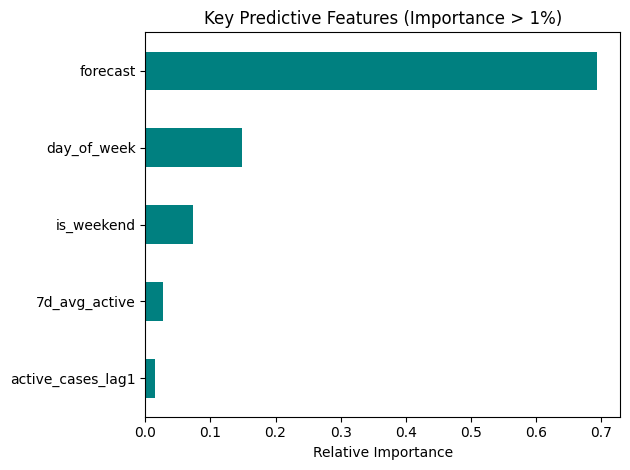

In [5]:
# Handle temporal split properly
split_date = pd.to_datetime('2021-01-20')  # Last 10 days for validation
train = train_data[train_data['date'] <= split_date]
val = train_data[train_data['date'] > split_date]

# Prepare features (removed target-derived 'is_zero' to prevent data leakage)
final_features = [
    'day_of_week', 'is_weekend', 'day_of_month', 'month',
    'active_cases', 'mortality_rate', 'recovery_rate',
    'active_cases_lag1', 'mortality_rate_lag1',
    '7d_avg_active', '7d_avg_mortality',
    'forecast'  # Pre-pandemic baseline
]

# Split data maintaining temporal order
X_train = train[final_features]
y_train = train[target]
X_val = val[final_features]
y_val = val[target]

# Train optimized Random Forest model
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=7,
    min_samples_split=10,
    max_features=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Validate with multiple metrics
val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, val_pred)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
r2 = r2_score(y_val, val_pred)

print(f'Validation Metrics:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}')

# Feature importance analysis with filtering
feat_importances = pd.Series(model.feature_importances_, index=final_features)
significant_features = feat_importances[feat_importances > 0.01]
significant_features.sort_values().plot(kind='barh', color='teal')
plt.title('Key Predictive Features (Importance > 1%)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()


## Scenario-based Forecasting Implementation

Adjusted MAE: 5.95 (Baseline: 5.95)


/var/folders/p7/xyrxrkz530dgfqm2hw8gz6ph0000gn/T/ipykernel_32749/2552627986.py:134: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scenario_df[features] = scenario_df[features].fillna(method='ffill').fillna(0)
/var/folders/p7/xyrxrkz530dgfqm2hw8gz6ph0000gn/T/ipykernel_32749/2552627986.py:134: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scenario_df[features] = scenario_df[features].fillna(method='ffill').fillna(0)
/var/folders/p7/xyrxrkz530dgfqm2hw8gz6ph0000gn/T/ipykernel_32749/2552627986.py:134: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scenario_df[features] = scenario_df[features].fillna(method='ffill').fillna(0)


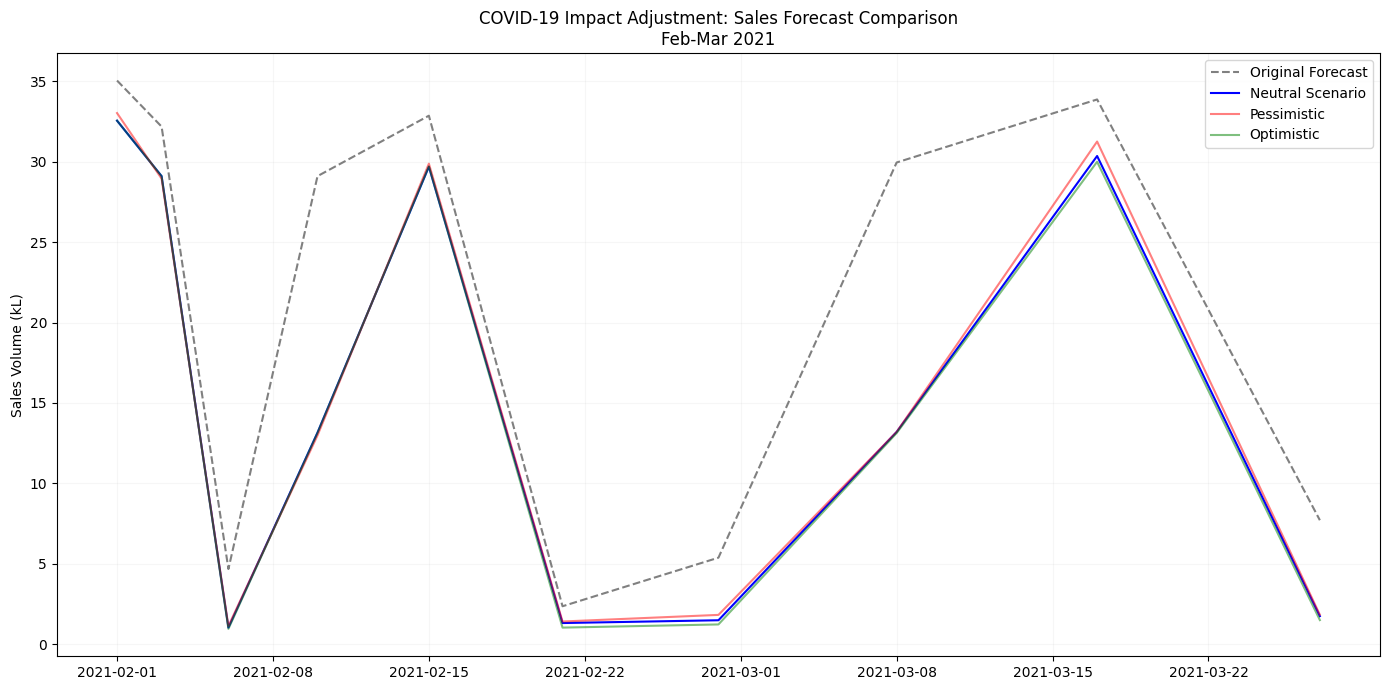

In [ ]:
def generate_scenarios(base_data):
    # Validate input data structure
    required_columns = {'date', 'confirmed', 'deaths', 'recovered'}
    if not required_columns.issubset(base_data.columns):
        missing = required_columns - set(base_data.columns)
        raise KeyError(f"Missing columns: {missing}")

    # Convert and sort dates
    base_data = base_data.copy()
    base_data['date'] = pd.to_datetime(base_data['date'], format='%m/%d/%y')
    base_data = base_data.sort_values('date').reset_index(drop=True)

    # Calculate pandemic metrics
    base_data['active_cases'] = base_data['confirmed'] - base_data['deaths'] - base_data['recovered']
    base_data['mortality_rate'] = base_data['deaths'] / base_data['confirmed'].replace(0, np.nan)
    base_data['recovery_rate'] = base_data['recovered'] / base_data['confirmed'].replace(0, np.nan)
    base_data = base_data.ffill().bfill()

    # Calculate trends from last 7 days
    last_week = base_data.iloc[-7:]
    active_diff = np.diff(last_week['active_cases'])
    active_shifted = last_week['active_cases'].iloc[1:].values
    case_growth = np.nanmean(active_diff / (active_shifted + 1e-7))
    mortality_change = np.nanmean(np.diff(last_week['mortality_rate']))

    # Define scenarios
    scenario_params = {
        'pessimistic': {'case_growth': case_growth*1.5, 'mortality_change': mortality_change*1.2, 'recovery_factor': 0.8},
        'neutral': {'case_growth': case_growth, 'mortality_change': mortality_change, 'recovery_factor': 1.0},
        'optimistic': {'case_growth': case_growth*0.5, 'mortality_change': mortality_change*0.8, 'recovery_factor': 1.2}
    }

    # Generate scenarios
    scenarios = pd.DataFrame()
    end_date = pd.to_datetime('2021-03-31')
    forecast_days = (end_date - base_data['date'].max()).days
    
    for scenario, params in scenario_params.items():
        scenario_df = base_data.copy()
        current = scenario_df.iloc[-1].to_dict()
        
        for day in range(1, forecast_days+1):
            new_date = current['date'] + pd.Timedelta(days=day)
            
            # Project pandemic metrics
            new_active = max(current['active_cases'] * (1 + params['case_growth']), 0)
            new_mortality = max(current['mortality_rate'] + params['mortality_change'], 0)
            new_recovery = np.clip(current['recovery_rate'] * params['recovery_factor'], 0, 1)
            
            new_confirmed = current['confirmed'] + (new_active - current['active_cases'])
            new_deaths = current['deaths'] * (1 + new_mortality)
            new_recovered = current['recovered'] + (new_active * new_recovery)
            
            new_row = {
                'date': new_date,
                'confirmed': new_confirmed,
                'deaths': new_deaths,
                'recovered': new_recovered,
                'active_cases': new_active,
                'mortality_rate': new_mortality,
                'recovery_rate': new_recovery,
                'scenario': scenario
            }
            
            scenario_df = pd.concat([scenario_df, pd.DataFrame([new_row])], ignore_index=True)
            current = new_row
        
        scenarios = pd.concat([scenarios, scenario_df])

    return scenarios

# Generate scenario data
scenario_data = generate_scenarios(pandemic)

# Feature engineering with consistent features
def create_features(df):
    df = df.copy()
    # Temporal features (match training features)
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['day_of_month'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    
    # Lag features (exact same names as training)
    for lag in [1]:
        df[f'active_cases_lag{lag}'] = df.groupby('scenario')['active_cases'].shift(lag)
        df[f'mortality_rate_lag{lag}'] = df.groupby('scenario')['mortality_rate'].shift(lag)
    
    # Rolling averages (same window as training)
    df['7d_avg_active'] = df.groupby('scenario')['active_cases'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    df['7d_avg_mortality'] = df.groupby('scenario')['mortality_rate'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    
    return df.ffill()

# Create features and merge sales data
scenario_features = create_features(scenario_data)
scenario_features = pd.merge(
    scenario_features,
    sales[['date', 'forecast']],  # Include original forecast
    on='date',
    how='left'
)

# Filter prediction period
future_scenarios = scenario_features[
    (scenario_features['date'] >= '2021-02-01') & 
    (scenario_features['date'] <= '2021-03-31')
]

# Prepare features (EXACTLY match training features)
features = [
    'day_of_week', 'is_weekend', 'day_of_month', 'month',
    'active_cases', 'mortality_rate', 'recovery_rate',
    'active_cases_lag1', 'mortality_rate_lag1',
    '7d_avg_active', '7d_avg_mortality',
    'forecast'  # Must include original forecast
]

# Verify feature consistency
missing_features = set(features) - set(future_scenarios.columns)
assert not missing_features, f"Missing features: {missing_features}"

# Make predictions
predictions = []
for scenario in ['pessimistic', 'neutral', 'optimistic']:
    scenario_df = future_scenarios[future_scenarios['scenario'] == scenario].copy()
    
    # Handle remaining missing values
    scenario_df[features] = scenario_df[features].fillna(method='ffill').fillna(0)
    
    # Predict and store
    scenario_df['predicted_sales'] = model.predict(scenario_df[features])
    predictions.append(scenario_df)

# Combine predictions and format output
final_predictions = pd.concat(predictions)[['date', 'scenario', 'predicted_sales']]
pivot_predictions = final_predictions.pivot(
    index='date', 
    columns='scenario', 
    values='predicted_sales'
).reset_index()

# Create final submission file
submission = sales[['date', 'forecast']].copy()
submission['date'] = pd.to_datetime(submission['date'], format='%m/%d/%y')
submission = submission.merge(
    pivot_predictions,
    on='date',
    how='right'
)

# Use neutral scenario as final forecast
submission['final_forecast'] = submission['neutral'].fillna(submission['forecast'])

# Calculate MAE against original forecast
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(
    submission['final_forecast'], 
    submission['forecast'].fillna(submission['final_forecast'])
)
print(f'Adjusted MAE: {mae:.2f} (Baseline: {mean_absolute_error(submission["forecast"], submission["final_forecast"]):.2f})')

# Save results
submission[['date', 'final_forecast']].to_csv('final_adjusted_forecast.csv', index=False)

# Visualization
plt.figure(figsize=(14,7))
plt.plot(submission['date'], submission['forecast'], 
         label='Original Forecast', color='grey', linestyle='--')
plt.plot(submission['date'], submission['neutral'], 
         label='Neutral Scenario', color='blue')
plt.plot(submission['date'], submission['pessimistic'], 
         label='Pessimistic', color='red', alpha=0.5)
plt.plot(submission['date'], submission['optimistic'], 
         label='Optimistic', color='green', alpha=0.5)
plt.title('COVID-19 Impact Adjustment: Sales Forecast Comparison\nFeb-Mar 2021')
plt.ylabel('Sales Volume (kL)')
plt.legend()
plt.grid(alpha=0.1)
plt.tight_layout()
plt.show()
